# Winter 2023 Scotia DSD - Modelling

Please note that Exploratory Analysis is done on a different file included in the folder under name 'Jojos_Data_Adventure_code_Exploratory'. 

### Style Guide
The following code attemps to follow google's python style guide. 
https://google.github.io/styleguide/pyguide.html

In [1]:
# Import needed libraries and define constants.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from imblearn.under_sampling import NearMiss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score


TEST_FILE_PATH = "/Users//Desktop/Winter 2023 Discovery Days/test_ScotiaDSD.csv"
TRAIN_FILE_PATH = "/Users//Desktop/Winter 2023 Discovery Days/train_ScotiaDSD.csv"
RESULT_EXPORT_FILE_PATH = "/Users//Desktop/Winter 2023 Discovery Days/submission.csv"

# Import training data as dataframe.
train_data = pd.read_csv('/Users//Desktop/Winter 2023 Discovery Days/train_ScotiaDSD.csv')

### Part 1: Investigate missing data

Only `USER_AGENT` and `CITY` columns contains missing/null data. Based on answers from Q&A sessions, those two columns are null when a transaction is not related to e-commerce. Thus, the null data is valid and don't need further processing.

In [2]:
# Check which columns contains missing data.
train_data.columns[train_data.isnull().sum(axis=0) != 0]

Index(['USER_AGENT', 'CITY'], dtype='object')

### Part 2: Preprocess data for the Random Forest Classifier

Since the Random Forest Classifiers can only process features with `dtype` that can be converted to `int` or `float`. We need to process features such as `EVENT_TIME`, `USER_AGENT` and `CITY` which has `dtype` `object`.

We convert `EVENT_TIME` to minutes since 00:00. We also classify `USER_AGENT` and `CITY` features and assign `int` values to each classification. If `USER_AGENT` and `CITY` is null, the `int` value will be `-1`.


In [3]:
# Converts EVENT_TIME columns to minutes since 00:00.
def to_minutes(timeStr):
    """Convert time string to minutes since 00:00.

    Args:
        timeStr: A string which takes the form %HH:%MM.

    Returns:
        An interger value.
    """
    timeList = timeStr.split(':')
    return int(timeList[0]) * 60 + int(timeList[0])

train_data['EVENT_TIME'] = train_data['EVENT_TIME'].apply(to_minutes)

# Categorize USER_AGENT and CITY columns
features_to_encode = list(train_data.select_dtypes(include = ['object']).columns) 
for i in features_to_encode:
    train_data[i] = train_data[i].astype('category')
    train_data[i] = train_data[i].cat.codes

### Part 3: Sample training dataset

By observation, the training data is imbalanced since the number of fraud transactions only takes up about `2.5%` of the training population. To avoid resultant model skewing towards predicting non-fraud, we use **Under-sampling**. Specifically, **Near Miss Method** to cut down transactions in the non-fraud category. Our target ratio between fraud to non-fraud is `0.25`.

In [4]:
# Apply Near Miss Under-sampling method to get train and test data samples.
X_population = train_data.drop(['TRANSACTION_ID', 'FRAUD_FLAG'], axis = 1)
Y_population = train_data['FRAUD_FLAG']
X_train, X_test, Y_train, Y_test = train_test_split(X_population, Y_population, test_size=0.3, random_state=42)

nearmiss = NearMiss(version=3, sampling_strategy=0.25)
X_train_nearmiss, Y_train_nearmiss= nearmiss.fit_resample(X_train, Y_train)
X_test_nearmiss, Y_test_nearmiss= nearmiss.fit_resample(X_test, Y_test)

# Check fraud to non-fraud ration in the samples.
print('testing set fraud ratio {}'.format(sum(Y_test_nearmiss)/len(Y_test_nearmiss)))
print('training set fraud ratio {}'.format(sum(Y_train_nearmiss)/len(Y_train_nearmiss)))

/Users//opt/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


testing set fraud ratio 0.2982862436313108
training set fraud ratio 0.30635017244877255


/Users//opt/anaconda3/lib/python3.9/site-packages/imblearn/under_sampling/_prototype_selection/_nearmiss.py:177: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


### Part 4: Use Random Forest Classifier

We apply Random Forest Classifier to our sampled training data. Then, we measure the prediction using F1 score.

In [5]:
# Configure Random Forest Classifier.
clf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,criterion='gini', max_depth=13, 
                             max_features='auto', min_impurity_decrease=0, min_samples_leaf=1, 
                             min_samples_split=5, min_weight_fraction_leaf=0, n_estimators=800,
                             n_jobs=None, oob_score=False)


# Run classifier on training data and predict testing data.
clf.fit(X_train_nearmiss, Y_train_nearmiss)
Y_pred_train_nearmiss = clf.predict(X_train_nearmiss)
Y_pred_test_nearmiss = clf.predict(X_test_nearmiss)

# Check prediction's F1 score.
print('f1 score on training: {}'.format(f1_score(Y_train_nearmiss,Y_pred_train_nearmiss)))
print('f1 score on testing: {}'.format(f1_score(Y_test_nearmiss,Y_pred_test_nearmiss)))

f1 score on training: 0.9132616487455197
f1 score on testing: 0.6805807622504537


### Part 5: Test model on another sample

Use the model on a randomly selected sample and check the f1 score.

In [6]:
# Randomly get a sample with 20000 transactions.
sample2 = train_data.sample(n = 20000, random_state=60)
X2 = sample2.drop(['TRANSACTION_ID', 'FRAUD_FLAG'], axis = 1)
Y2 = sample2['FRAUD_FLAG']

# Use model to predict.
y_pred_test2 = clf.predict(X2)

# Check prediction's F1 score.
print('f1 score on testing: {}'.format(f1_score(Y2,y_pred_test2)))

f1 score on testing: 0.6441281138790035


### Part 6: Show significant features

Use Matplot to plot the significant features in the Random Forest Classifier model.

No handles with labels found to put in legend.


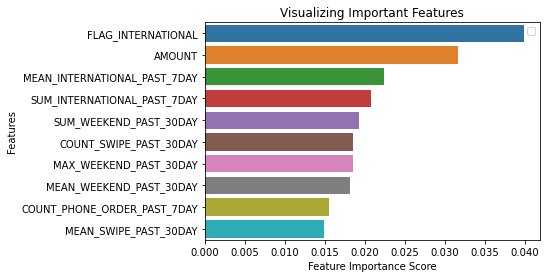

In [7]:
feature_imp = pd.Series(clf.feature_importances_,index=X_population.columns).sort_values(ascending=False).nlargest(10)
%matplotlib inline

# Creating a bar plot.
sns.barplot(x=feature_imp, y=feature_imp.index)

# Add labels to bar plot.
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

### Part 7: Export prediction to csv file

In [11]:
# Import testing data as dataframe.
test_data = pd.read_csv(TEST_FILE_PATH)

# Preprocess EVENT_TIME column in testing data.
test_data['EVENT_TIME'] = test_data['EVENT_TIME'].apply(to_minutes)

# Categorize USER_AGENT and CITY columns in testing data.
for i in features_to_encode:
    test_data[i] = test_data[i].astype('category')
    test_data[i] = test_data[i].cat.codes

# Generate prediction and probability.
X_result=test_data[X_population.columns]
Y_result=clf.predict(X_result)
Y_prob=clf.predict_proba(X_result)
test_data["FRAUD_FLAG"]=Y_result
test_data[["PROB_NOT_FRAUD", "PROB_FRAUD"]] = Y_prob

# Write FRAUD_FLAG and PROBABILITY to testing dataframe.
test_data["PROBABILITY"] = test_data["PROB_FRAUD"]

# Export result to csv file.
test_data.to_csv(RESULT_EXPORT_FILE_PATH, 
                 columns=["TRANSACTION_ID", "FRAUD_FLAG", "PROBABILITY"], 
                 header=["TRANSACTION_ID", "PERDICTION", "PROBABILITY"],
                 index=False)